# Imports

In [1]:
#imports
import pandas as pd
import numpy as np
import spotipy
import spotipy.util as util
import json
import math
import types
from datetime import datetime
import csv
from dateutil.parser import parse

## Creating the docs to work from

In [2]:
#appending the csvs I created in the initial gathering together
playlists1 = pd.read_csv('../data/raw/playlists.csv')
playlists2 = pd.read_csv('../data/raw/playlists2.csv')
playlists3 = pd.read_csv('../data/raw/playlists3.csv')

playlists_read = playlists1.append(playlists2)
playlists_read = playlists_read.append(playlists3)

In [3]:
playlists_read.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2556 entries, 0 to 647
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Unnamed: 0   2556 non-null   int64 
 1   description  2348 non-null   object
 2   spotify_id   2556 non-null   object
 3   name         2553 non-null   object
 4   no_tracks    2556 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 119.8+ KB


In [4]:
playlists_read.head(10)

,Unnamed: 0,description,spotify_id,name,no_tracks
0,0,Justin Bieber is on top of the Hottest 50!,37i9dQZF1DXcBWIGoYBM5M,Today's Top Hits,50
1,1,"Music from Lil Durk, Playboi Carti and Kid Cudi.",37i9dQZF1DX0XUsuxWHRQd,RapCaviar,50
2,2,The newest music from Foo Fighters along with ...,37i9dQZF1DXcF6B6QPhFDv,Rock This,50
3,3,The world's biggest dance hits. Music from Ima...,37i9dQZF1DX4dyzvuaRJ0n,mint,79
4,4,"Today's top country hits of the week, worldwid...",37i9dQZF1DX1lVhptIYRda,Hot Country,53
5,5,"Today's top Latin hits are right here, on ¡Viv...",37i9dQZF1DX10zKzsJ2jva,¡Viva Latino!,50
6,6,The pulse of R&B music today. Cover: PARTYNEX...,37i9dQZF1DX4SBhb3fqCJd,Are & Be,36
7,7,Your daily update of the most played tracks in...,37i9dQZEVXbLRQDuF5jeBp,United States Top 50,50
8,8,Your daily update of the most played tracks ri...,37i9dQZEVXbMDoHDwVN2tF,Global Top 50,50
9,9,Your daily update of the most viral tracks in ...,37i9dQZEVXbLiRSasKsNU9,Global Viral 50,50


In [5]:
# deduplicate the list on the spotify id -- again losing data at this point isn't a huge deal
# as this is about getting a variety of playlists for analysis, but none are required to make
# the tool better

dedup_playlists = playlists_read.drop_duplicates(subset='spotify_id')

In [6]:
# checking the dedup worked
dedup_playlists.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2186 entries, 0 to 647
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Unnamed: 0   2186 non-null   int64 
 1   description  1979 non-null   object
 2   spotify_id   2186 non-null   object
 3   name         2183 non-null   object
 4   no_tracks    2186 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 102.5+ KB


In [7]:
# creating a test batch to work with before running the api
from random import seed
from random import sample
# seed random number generator
seed(1)
# prepare a sequence
sequence = [i for i in range(2186)]
# select a subset without replacement
subset = sample(sequence, 50)

x = 0
test_total = []
while x < len(subset):
    list = [dedup_playlists.iloc[subset[x],0], 
            dedup_playlists.iloc[subset[x],1], 
            dedup_playlists.iloc[subset[x],2],
            dedup_playlists.iloc[subset[x],3],
            dedup_playlists.iloc[subset[x],4]
           ]
    test_total.append(list)
    x += 1

print(test_total)
test_df = pd.DataFrame(test_total)
test_df.head()

[[610, '<a href="spotify:genre:house">House</a> music lives here. United in one house. Cover: Chris Lake & Armand Van Helden', '37i9dQZF1DXa8NOEUWPn9W', 'Housewerk', 120], [274, 'New age music for balancing mind and body.', '37i9dQZF1DX9uKNf5jGX6m', 'Yoga & Meditation', 201], [1299, 'You bring the ingredients. We bring the flavor. Enjoy la cena!', '37i9dQZF1DX2zAr9vdmFlU', 'Latin Dinner', 100], [535, 'A collection of songs from <a href="spotify:user:nytrvduf711vc7ja3kv9vwgnm">Tony Hawk\'s Pro Skater 1 + 2</a>.', '37i9dQZF1DX6F6y6vVLZ8H', "Tony Hawk's Pro Skater 1 + 2", 53], [450, 'Our official Beauregard playlist, created by the always fierce Marisha Ray. Because sleeves are bullsh*t. Playlist art by Ash || @planarbindings', '2CKDWoWdpkxsO3qeczwrd7', 'Beauregard (Mighty Nein)', 12], [262, "NOW That's What I Call Music! 99. Featuring Dua Lipa, Bruno Mars, Jess Glynne, Rudimental and more!", '3x4qEzYA6m0Ze6NcTM0THI', 'NOW 99 - Latest Chart Hits', 45], [355, nan, '2oWVMIA4GAsBmav3qsSfKI',

,0,1,2,3,4
0,610,"<a href=""spotify:genre:house"">House</a> music ...",37i9dQZF1DXa8NOEUWPn9W,Housewerk,120
1,274,New age music for balancing mind and body.,37i9dQZF1DX9uKNf5jGX6m,Yoga & Meditation,201
2,1299,You bring the ingredients. We bring the flavor...,37i9dQZF1DX2zAr9vdmFlU,Latin Dinner,100
3,535,"A collection of songs from <a href=""spotify:us...",37i9dQZF1DX6F6y6vVLZ8H,Tony Hawk's Pro Skater 1 + 2,53
4,450,"Our official Beauregard playlist, created by t...",2CKDWoWdpkxsO3qeczwrd7,Beauregard (Mighty Nein),12


# Spotify Work

In [8]:
# authorization for spotify
token = util.prompt_for_user_token(
        username="rosey.waters@gmail.com",
        scope="user-read-recently-played user-read-private user-top-read user-read-currently-playing",
        client_id="e7b1f1096c82471d89d1db8030b82dd9",
        client_secret="5e635c87338b4729bc9a8bd007c2cbe1",
        redirect_uri="https://www.google.it/")

spotify = spotipy.Spotify(auth=token)

In [9]:
# function that gets the track listing for songs from a playlist id, this will be useful later!

def total_track_listing(spotify_id):
    # create the url from the spotify id and the offset
    def create_url(spotify_id, offset):
        playlist = 'https://api.spotify.com/v1/playlists/' + spotify_id + '/tracks?offset=' + str(offset)
        return playlist

    # get the json information
    def get_json(playlist):
        try:
            def track_listing(self, limit=100):
                return self._get(playlist, limit=limit)

            spotify.track_listing = types.MethodType(track_listing, spotify)

            trackers = spotify.track_listing(limit=100)

            data = json.dumps(trackers, sort_keys=True, indent=2)

            data_parse = json.loads(data)

            return data_parse
        except:
            return ""
    
    def get_tracks(json):
        # create an empty list to add the information into
        created_list = []
        data = json["items"]
        for i in data:
        
            try:
                track_name = i["track"]["name"]
                primary_artist = i["track"]["artists"][0]["name"]
                artist_list = []
                for artist in i["track"]["artists"]:
                    artist_list.append(artist["name"])
                track_id = i["track"]["id"]
                info = [track_name, primary_artist, artist_list, track_id]
                created_list.append(info)
            except: 
                pass
            
        return created_list
    # this part cycles through the tracks if there are more than 100
    final = []
    offsetter = 0
    try:
        total = get_json(create_url(spotify_id,0))['total']

        while offsetter < total:
            run = get_json(create_url(spotify_id,offsetter))
            created = get_tracks(run)
            final += created
            offsetter += 100

        return final
    except:
        return 'playlist does not exist'

In [10]:
# runs the API calls and tells you when they've been done
player = 0
total_list = []
while player < len(test_df):
    playlisting = total_track_listing(test_df.iloc[player,2])
    total_list.append(playlisting)
    player += 1
    print(str(player) + ' done')

1 done
2 done
3 done
4 done
5 done
6 done
7 done
8 done
9 done
10 done
11 done
12 done
13 done
14 done
15 done
16 done
17 done
18 done
19 done
20 done
21 done
22 done
23 done
24 done
25 done
26 done
27 done
28 done
29 done
30 done
31 done
32 done
33 done
34 done
35 done
36 done
37 done
38 done
39 done
40 done
41 done
42 done
43 done
44 done
45 done
46 done
47 done
48 done
49 done
50 done


In [11]:
# joins together the data into one dataframe for easier manipulation
total = pd.DataFrame(total_list[1])
counting = 2
while counting < len(total_list):
    try:
        total = total.append(pd.DataFrame(total_list[counting]))
    except:
        pass
    counting += 1

total.head()

,0,1,2,3
0,Astral Wonder,Moon Oceans,[Moon Oceans],7En6m2Yg3J1zAq895bxl78
1,Evergreen,Cooper Sams,[Cooper Sams],633YySlXq6qxSdCLFovXdv
2,Karlavagnen,Karlavagnen,[Karlavagnen],7kdnp9XpskkNjGDRlmb8nw
3,Montana,Isobel Belano,[Isobel Belano],0gBjWQIJ9KcdzT26UzkNqn
4,Electron,Sisi Row,[Sisi Row],0KkNeFOoAKW0NkhaleFeGk


### Data Cleaning

In [12]:
# I'm going to start by looking at the tracks individually for clarity and then return to the playlists later
# right now it's about connecting the track to the genius page

# Adjusting the dataframe etc
total = total.rename(columns={0:'track_name',1:'primary_artist',2:'artists',3:'id'})
total.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4977 entries, 0 to 49
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   track_name      4977 non-null   object
 1   primary_artist  4977 non-null   object
 2   artists         4977 non-null   object
 3   id              4977 non-null   object
dtypes: object(4)
memory usage: 194.4+ KB


In [13]:
# imports
import requests
from bs4 import BeautifulSoup
import csv
import re
from unidecode import unidecode

In [61]:
# test if the links are viable
def genius_search(track_name, primary_artist, spotify_id, additional=''):

#artist processing
    
    # then adjusts non-latin characters
    # removes the spaces and turns them into dashes
    artist = primary_artist.replace("&","and")
    artist = unidecode(artist)
    artist = artist.replace("/","-")
    artist = re.sub("[^a-zA-z0-9 -]", "", artist)
    artist = artist.replace(" ","-")
    
#track processing
    # removes some of common features
    # then spaces and dashes
    track = track_name.replace("&","and")
    track = unidecode(track)
    track = track.replace("/","-")
    track = re.sub("[^a-zA-z0-9 -]", "", track)
    track = track.split('feat')[0]
    track = track.split('with')[0]
    track = track.strip().replace(" ","-")
    
    # creates the url
    url = "https://genius.com/" + artist + '-' + track + "-lyrics"
    
    # remove double dashes
    url = url.replace("--","-")
    singles = url.split('--')
    if len(singles) > 1:
        url = singles[0] + '-lyrics'
    
    try: 
        response = requests.get(url)
        html = response.text
        soup = BeautifulSoup(html, "html.parser")

        lyrics = soup.findAll('div', attrs={'class': 'lyrics'})
        text = lyrics[0].p.get_text()
        tester = text
        
    except:
        if len(additional) > 1:
            other = 1
            while other < len(additional):
                second = re.sub("[^a-zA-z0-9 -]", "", additional[other])
                second = second.replace(" ","-")
                new = '-and-' + second
                other += 1
            url = "https://genius.com/" + artist + '-and-' + second + '-' + track + "-lyrics"
        
            try:
                response = requests.get(url)
                html = response.text
                soup = BeautifulSoup(html, "html.parser")

                lyrics = soup.findAll('div', attrs={'class': 'lyrics'})
                text = lyrics[0].p.get_text()
                tester = text
            except:
                try:
                    track = track_name.replace("&","and")
                    track = re.sub("[^a-zA-z0-9 -]", "", track)
                    track = track.split('feat')[0]
                    track = track.split('with')[0]
                    track = track.strip().replace(" ","-")
                    artist = primary_artist.replace("&","and")
                    artist = re.sub("[^a-zA-z0-9 -]", "", artist)
                    artist = artist.replace(" ","-")
                    url = "https://genius.com/" + artist + '-' + track + "-lyrics"
                    
                    response = requests.get(url)
                    html = response.text
                    soup = BeautifulSoup(html, "html.parser")

                    lyrics = soup.findAll('div', attrs={'class': 'lyrics'})
                    text = lyrics[0].p.get_text()
                    tester = text
                except:
                    tester = [url, 'bad', spotify_id, artist, additional]
        else:
            tester = [url, 'bad', spotify_id, artist, additional]
    
    return tester
    

parse = 3000
parse1 = 4000
error_list = []
test = []

while parse < parse1:
    genius_tester = genius_search(total.iloc[parse,0], total.iloc[parse,1],total.iloc[parse,3],total.iloc[parse,2])
    
    if genius_tester[1] == 'bad':
        error_list.append(genius_tester)
        print(parse, ' bad')
    else:
        test.append(genius_tester)
        print(parse, ' good')
    parse += 1


3000  good
3001  good
3002  good
3003  good
3004  good
3005  good
3006  good
3007  good
3008  good
3009  good
3010  bad
3011  good
3012  good
3013  good
3014  good
3015  bad
3016  good
3017  good
3018  good
3019  good
3020  good
3021  good
3022  good
3023  good
3024  good
3025  good
3026  good
3027  good
3028  good
3029  good
3030  good
3031  good
3032  good
3033  good
3034  good
3035  good
3036  good
3037  good
3038  good
3039  good
3040  good
3041  good
3042  good
3043  good
3044  good
3045  good
3046  good
3047  good
3048  good
3049  good
3050  good
3051  good
3052  good
3053  good
3054  bad
3055  good
3056  good
3057  good
3058  good
3059  good
3060  good
3061  good
3062  good
3063  good
3064  good
3065  good
3066  good
3067  good
3068  good
3069  good
3070  good
3071  good
3072  good
3073  good
3074  good
3075  good
3076  good
3077  good
3078  good
3079  good
3080  good
3081  good
3082  good
3083  good
3084  good
3085  good
3086  good
3087  good
3088  good
3089  good
3090  good
30

3752  good
3753  good
3754  good
3755  good
3756  good
3757  good
3758  good
3759  good
3760  good
3761  good
3762  good
3763  good
3764  good
3765  good
3766  good
3767  good
3768  good
3769  good
3770  good
3771  good
3772  good
3773  good
3774  good
3775  good
3776  good
3777  good
3778  good
3779  good
3780  good
3781  good
3782  good
3783  good
3784  good
3785  good
3786  good
3787  good
3788  good
3789  good
3790  good
3791  good
3792  good
3793  good
3794  good
3795  good
3796  good
3797  good
3798  good
3799  good
3800  good
3801  good
3802  good
3803  good
3804  good
3805  good
3806  good
3807  good
3808  good
3809  good
3810  good
3811  good
3812  good
3813  good
3814  good
3815  bad
3816  good
3817  good
3818  good
3819  good
3820  good
3821  bad
3822  good
3823  good
3824  good
3825  good
3826  good
3827  good
3828  good
3829  good
3830  good
3831  good
3832  good
3833  good
3834  good
3835  good
3836  good
3837  good
3838  good
3839  good
3840  good
3841  good
3842  bad
38

In [62]:
# just in case there's something I can still grab, but honestly, probably not
print(error_list)
print(len(error_list))

[['https://genius.com/Sigi-Schwab-My-Love-Is-a-Tango-lyrics', 'bad', '3K8U3bAKvV8X7IieYnnlqD', 'Sigi-Schwab', ['Sigi Schwab', 'Guillermo Marchena']], ['https://genius.com/Chris-Thompson-The-Challenge-lyrics', 'bad', '1kdL67gXh8XY2ux3k4BURR', 'Chris-Thompson', ['Chris Thompson']], ['https://genius.com/Tina-Turner-Whats-Love-Got-to-Do-lyrics', 'bad', '3ErsOxqe2RmXkR65wkygDz', 'Tina-Turner', ['Tina Turner']], ['https://genius.com/Randy-Crawford-Cant-Stand-the-Pain-lyrics', 'bad', '5tEQ9kzRKzrE3zwLeYO22n', 'Randy-Crawford', ['Randy Crawford']], ['https://genius.com/Monte-Luv-Dont-Stop-the-Music-lyrics', 'bad', '10PXkxcj3t64eyBUOAJtJs', 'Monte-Luv', ['Monte Luv', 'Simon Harris', 'Dina Carroll']], ['https://genius.com/The-Catch-25-Years-Single-Version-lyrics', 'bad', '6jGJccs7dFynNXmOkOvILY', 'The-Catch', ['The Catch']], ['https://genius.com/Ofra-Haza-Im-Nin-Alu-lyrics', 'bad', '1shulSNYJKAmUft9azXNJW', 'Ofra-Haza', ['Ofra Haza']], ['https://genius.com/The-Todd-Terry-Project-Weekend-lyrics',

In [63]:
# let's see the word cloud!
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

In [64]:
from collections import Counter
Counter(total_lyrics.split(" ")).most_common(10)

[('you', 1594),
 ('i', 1065),
 ('the', 1025),
 ('me', 823),
 ('to', 776),
 ('it', 530),
 ('', 518),
 ('a', 483),
 ('my', 437),
 ('and', 397)]

In [65]:
# removes anything between square brackets, which seems to be genius's way of
# doing things like "chorus" etc
total_lyrics = ''
for lyric in test:
    gen = re.sub("([\[]).*?([\]])", "", lyric)
    gen = re.sub("[^a-zA-z0-9 -]", "", gen)
    total_lyrics += gen
    
total_lyrics = total_lyrics.lower()

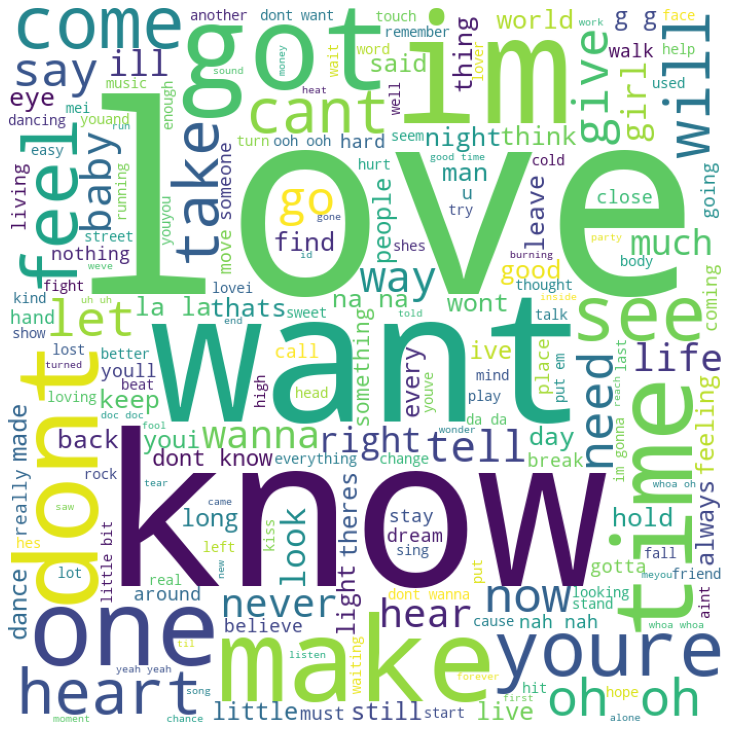

In [66]:
# build a word cloud -- just to see if there's something else that should obviously be taken out
wordcloud = WordCloud(width = 700, height = 700, 
                background_color ='white', 
                min_font_size = 10).generate(total_lyrics) 
  
# plot the WordCloud image                        
plt.figure(figsize = (10, 10), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()